# Illustrations for using Neural Nets for Approximation a 2d Surface
Author: Joerg Kienitz (finciraptor.de, https://github.com/Lapsilago) for the workshop Machine Learning for Option Pricing, Calibration and Hedging Workshop with Nikolai Nowaczyk ( https://github.com/niknow; https://github.com/niknow/machine-learning-examples )

In [1]:
import numpy as np

from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# First some helper functions to generate samples of your target function
The main idea of these functions is to generates sampels for y=f(x) with x R^2

If you generate N times as 2D sample then tensorflow and Keras expect your data to be organized in a Nx2 matrix.

If your data was a set of N RGB (red, green, blue) colors then it would exect tensor of  Nx3.

If your data was a set of N images, each image W by H pixels then it would exect tensor of rank 3 (3d matrix) NxWxH.

The first dimension is always the number of samples N (called the "batch size"). This dimension is allowed to be variable, but the other dimension -like x is 2D in this sin(x0)cos(x1) example- need to stay fixed. During traning you could in principle trains first with batches of 100 samples and then at some point change to 1 sample or 10.000 samples.. Nobody does this, expect maybe that that you might use 100 during traning, and than a diferent number of samples during usage of the model in production. We'll do this at the bottom of this notebook when we evaluate the NN fit and its error surface...

In [2]:
# sample the input space of your function randomly
def sample_x_random(N):
    x0 = np.random.uniform(0, 12.5, N)
    x1 = np.random.uniform(0, 12.5, N)
    return np.column_stack((x0, x1))    
    # or simply return np.random.uniform(0, 12.5, size=(N,2))

# sample the input space of your function on 1 2D grid
def sample_x_grid(N):
    x0 = np.linspace(0, 12.5, N)
    x1 = np.linspace(0, 12.5, N)
    
    #outer product
    x0_grid, x1_grid = np.meshgrid(x0, x1)
    
    # reshape and stack side by side
    return np.column_stack([x0_grid.flatten(), x1_grid.flatten()])

# Conpute the function
def f(x):
    return (np.sin(x[:,0]) * np.cos(x[:,1])).reshape(-1,1)

# example: draw 5 samples from the function

In [3]:
x = sample_x_random(5)
y = f(x)

print('x is a',x.shape,'matrix\n', x)
print()
print('y is a',y.shape,'matrix\n', y)

x is a (5, 2) matrix
 [[10.19766871  7.4034327 ]
 [ 1.00861312  6.46333887]
 [ 4.40094854  8.48916605]
 [11.51949713  4.08625774]
 [ 5.95712666  8.84134903]]

y is a (5, 1) matrix
 [[-0.30404132]
 [ 0.83240039]
 [ 0.56478293]
 [ 0.50740828]
 [ 0.2673254 ]]


# plot the function evaluated at random points

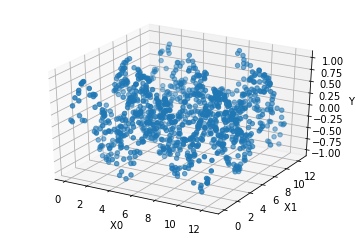

In [4]:
x = sample_x_random(1000)
y = f(x)


# --------------------

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,0], x[:,1], y)
ax.set_xlabel('X0 ')
ax.set_ylabel('X1 ')
ax.set_zlabel('Y ')
plt.show()

# plot the function evaluated on a grid

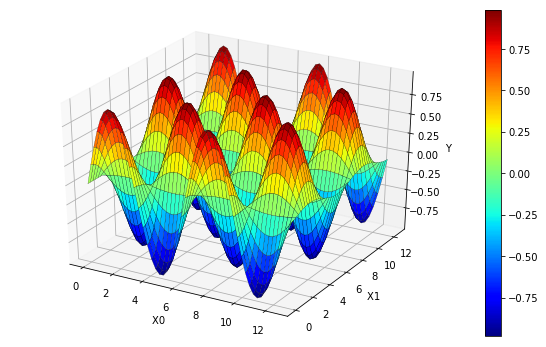

In [5]:
N = 50
x = sample_x_grid(N)
y = f(x)

# --------------------

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(
    x[:,0].reshape(N,N), 
    x[:,1].reshape(N,N), 
    y.reshape(N,N), 
    rstride=1, 
    cstride=1, 
    linewidth=.2,
    edgecolors='k',
    cmap=cm.jet
)
ax.set_zlim3d(np.min(y), np.max(y))

fig.colorbar(surf)

ax.set_xlabel('X0 ')
ax.set_ylabel('X1 ')
ax.set_zlabel('Y ')
plt.show()

The **input_shape** needs to be (2,) . Remember the Nx2 matrix of inputs? Input_shape needs to be set that shape..except you skip the first dimension -the batch size N-. That dimension can be variable so Keras will infer it from the size of the data you pass to the Network.
If would have been logical if you could say "input_shape=2" but Keras support higher dimensional data structures (like images and video chunks) and so it wants to have a *list* of dimensions. Is you say (2,) or [2] then python sees that as a collection of integers, and it can itterate them -even when thre is just 1 value in te list-.

Empiricaly it's often he case that for intermediate layer a "relu" activation functoin works better thn sigmoid. More units per layer can also help, and having more layer when function are complicated (thi function has lots of humps) might also help.


In [6]:
model = Sequential([
    Dense(100, input_shape=(2,)),
    Activation('relu'),
    Dense(100),
    Activation('relu'),
    Dense(1)
])

Metrics is an optional argument and it allows you to compute additional metrics you want to monitor during training. Even though is optimizes only for the mean square error you might still be interested to examine other performance measures (mean *absolute* devation e.g.).. 
For *classifiers* you can "accuracy" which measure the number of times the output of the NN was exactly correct, but this is a *regression*  problem with real values outputs (you correctly used least squared error) and then you don't have accuracy. 

The SGD optimizer is fine, but Adam is more commonly used, and in this case it works much better:
* SGD gives an error of 1% after 100 epochs
* ADAM gives an error of 0.3% after 10 epochs

In [7]:
model.compile(loss='mean_squared_error', optimizer=Adam())   

Below we first generate a training set of 100k samples. We then fit the model. In each step we pick 100 random samples from our set of 100k and adjust the NN weights.

In [8]:
x = sample_x_random(100*1000)
y = f(x)

model.fit(x, y, epochs=10)

Epoch 1/10
100000/100000 [==============================] - 14s 138us/step - loss: 0.1977
Epoch 2/10
100000/100000 [==============================] - 11s 112us/step - loss: 0.1118
Epoch 3/10
100000/100000 [==============================] - 11s 113us/step - loss: 0.0546
Epoch 4/10
100000/100000 [==============================] - 11s 114us/step - loss: 0.0314
Epoch 5/10
100000/100000 [==============================] - 11s 115us/step - loss: 0.0220
Epoch 6/10
100000/100000 [==============================] - 11s 115us/step - loss: 0.0089
Epoch 7/10
100000/100000 [==============================] - 11s 115us/step - loss: 0.0053
Epoch 8/10
100000/100000 [==============================] - 11s 115us/step - loss: 0.0046
Epoch 9/10
100000/100000 [==============================] - 11s 113us/step - loss: 0.0041
Epoch 10/10
100000/100000 [==============================] - 11s 114us/step - loss: 0.0039


# See what the trained NN does

In [9]:
N = 50
x = sample_x_grid(N)

y = f(x)

y_nn = model.predict(x)

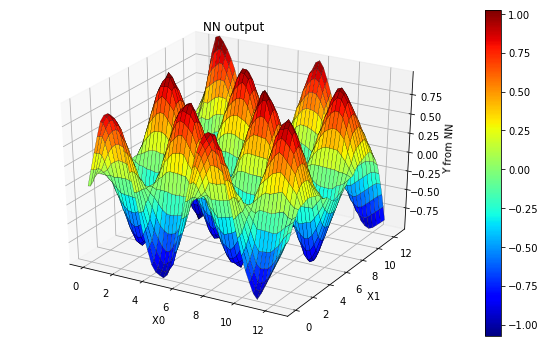

In [10]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(
    x[:,0].reshape(N,N), 
    x[:,1].reshape(N,N), 
    y_nn.reshape(N,N), 
    rstride=1, 
    cstride=1, 
    linewidth=.2,
    edgecolors='k',
    cmap=cm.jet
)
ax.set_zlim3d(np.min(y), np.max(y))

fig.colorbar(surf)

ax.set_xlabel('X0 ')
ax.set_ylabel('X1 ')
ax.set_zlabel('Y from NN')
plt.title('NN output')
plt.show()

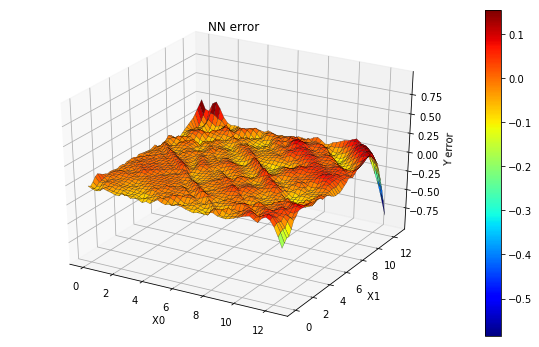

In [11]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(
    x[:,0].reshape(N,N), 
    x[:,1].reshape(N,N), 
    (y_nn-y).reshape(N,N), 
    rstride=1, 
    cstride=1, 
    linewidth=.2,
    edgecolors='k',
    cmap=cm.jet
)
ax.set_zlim3d(np.min(y), np.max(y))

fig.colorbar(surf)

ax.set_xlabel('X0 ')
ax.set_ylabel('X1 ')
ax.set_zlabel('Y error')
plt.title('NN error')
plt.show()

# Mostly good, except for that corner

It could be that we have undersampled that region? Or maybe we should have let it train for a bit longer -maybe it has not converged yet-?

Or maybe we can fix it by using the mean quadratic error? Minimizing higher orders errors terms penalize the largest deviation more than lower order error terms...

We are going to implement a custon loss function, optimize towards this new loss function, .. buy we still want to see the mean_square_error_metric..

In [12]:
import tensorflow

def mean_quadratic_error(y_true, y_pred):
    return tensorflow.keras.backend.mean(
        tensorflow.keras.backend.pow(y_pred - y_true, 4),
        axis=-1
    )

In [13]:
model = Sequential([
    Dense(100, input_shape=(2,)),
    Activation('relu'),
    Dense(100),
    Activation('relu'),
    Dense(1)
])

model.compile(loss=mean_quadratic_error, optimizer=Adam(), metrics=['mean_squared_error'])   

x = sample_x_random(100*1000)
y = f(x)

model.fit(x, y, epochs=10)

Epoch 1/10
100000/100000 [==============================] - 12s 123us/step - loss: 0.1195 - mean_squared_error: 0.2135
Epoch 2/10
100000/100000 [==============================] - 12s 118us/step - loss: 0.0580 - mean_squared_error: 0.1565
Epoch 3/10
100000/100000 [==============================] - 12s 117us/step - loss: 0.0245 - mean_squared_error: 0.1070
Epoch 4/10
100000/100000 [==============================] - 12s 116us/step - loss: 0.0135 - mean_squared_error: 0.0744
Epoch 5/10
100000/100000 [==============================] - 12s 117us/step - loss: 0.0080 - mean_squared_error: 0.0506
Epoch 6/10
100000/100000 [==============================] - 12s 118us/step - loss: 0.0030 - mean_squared_error: 0.0280
Epoch 7/10
100000/100000 [==============================] - 12s 118us/step - loss: 0.0011 - mean_squared_error: 0.0157
Epoch 8/10
100000/100000 [==============================] - 12s 116us/step - loss: 8.6734e-04 - mean_squared_error: 0.0115
Epoch 9/10
100000/100000 [==================

In [14]:
N = 50
x = sample_x_grid(N)

y = f(x).reshape(-1,1)

y_nn = model.predict(x)

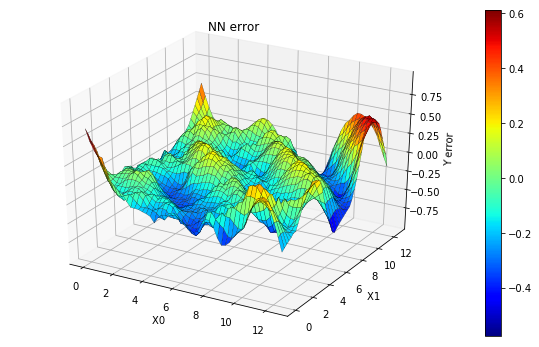

In [15]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(
    x[:,0].reshape(N,N), 
    x[:,1].reshape(N,N), 
    (y_nn-y).reshape(N,N), 
    rstride=1, 
    cstride=1, 
    linewidth=.2,
    edgecolors='k',
    cmap=cm.jet
)
ax.set_zlim3d(np.min(y), np.max(y))

fig.colorbar(surf)

ax.set_xlabel('X0 ')
ax.set_ylabel('X1 ')
ax.set_zlabel('Y error')
plt.title('NN error')
plt.show()

hmmm... somewhat better, but the regular quatratic loss and maybe a higher number of epochs might work better..